

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>



## Comparative Analysis of Linear Regression, Support Vector Regression, and Random Forest Models for EUR Estimation in Unconventional Wells

#### Bruno Reinoso

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

Some of this code block is from Professor Michael Pyrcz (@GeostatsGuy) from GeostatsGuy GitHub.


### Executive Summary

The estimation of Estimated Ultimate Recovery (EUR) plays a pivotal role in the development of unconventional wells. EUR estimation requires several months of production data, which is not available during the initial production months, to achieve accurate estimations and make informed economic decisions. Data-driven models can be employed to obtain precise estimates using drilling and completion data for EUR estimations.

I conducted a comparative analysis among Linear Regression, Support Vector Machine (SVM), and Random Forest to estimate the 20-year gas EUR, incorporating multiple well/reservoir attributes such as geology, drilling, and completion features. Our dataset comprises 507 dry gas horizontal multistage fractured wells in a shale unconventional play. Our findings revealed that Linear Regression lacks accuracy in estimating EUR due to the extensive number of features. Conversely, Random Forest emerged as a highly robust model capable of minimizing errors and delivering excellent results. Additionally, we tested SVM for regression and, following hyperparameter optimization, achieved comparable results to Random Forest with less computational effort.


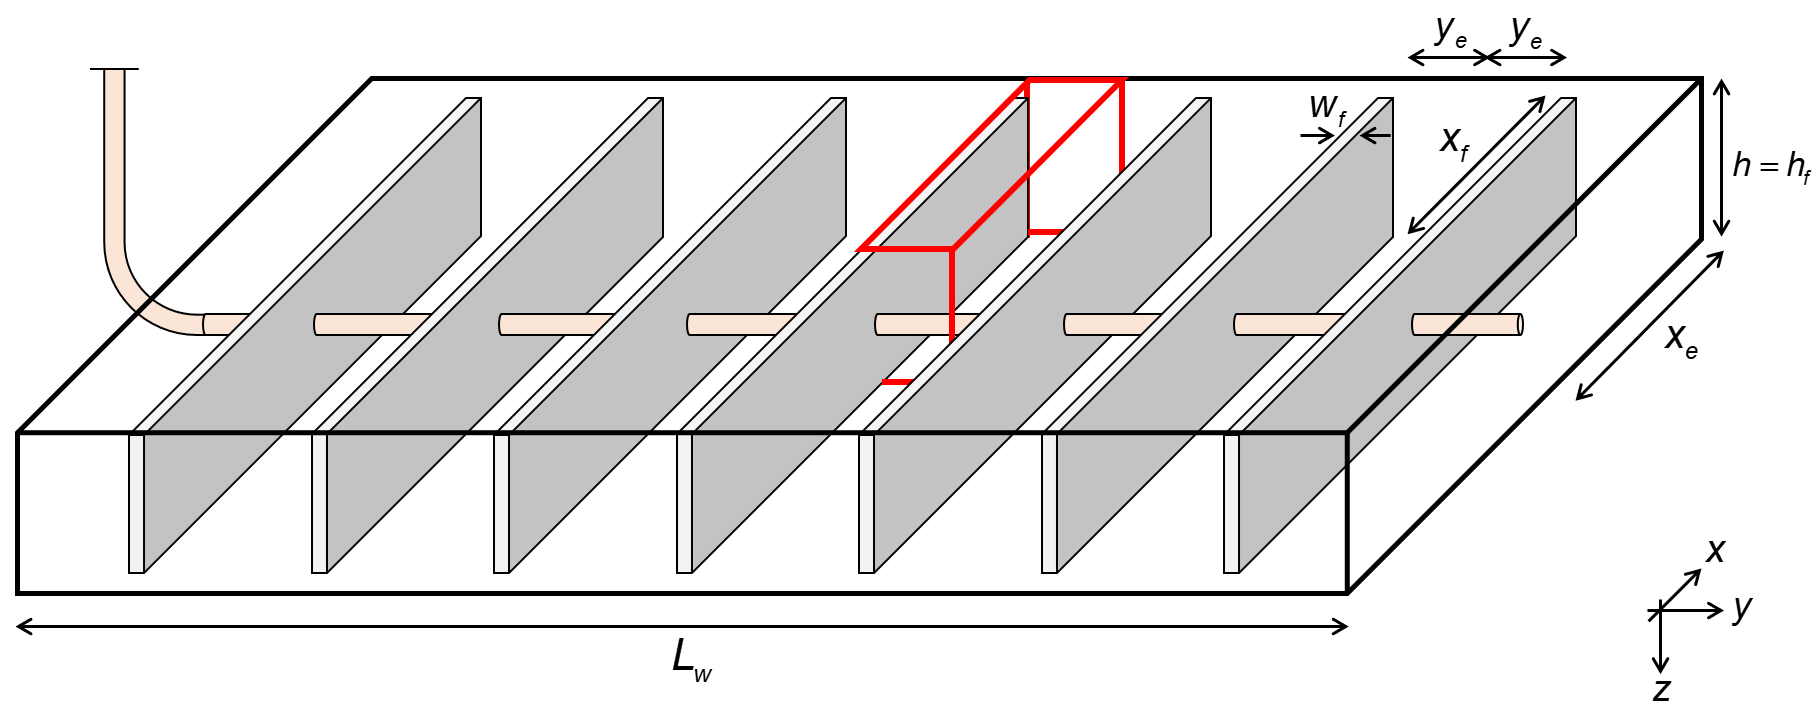

In unconventional wells, critical parameters profoundly influence the Estimated Ultimate Recovery (EUR), encompassing factors like lateral length, fracture length, distance between fractures, thickness, and petrophysical properties. (Figure 1) The lateral length, representing the wellbore's total horizontal extent, impacts reservoir exposure and, consequently, resource recovery. Fracture length, indicative of the stimulated zone's reach, directly influences fluid flow efficiency and resource extraction. The spatial arrangement of fractures, including the distance between them, governs stimulation effectiveness and reservoir connectivity. Simultaneously, the petrophysical properties, encompassing characteristics like porosity and permeability, play a vital role in gauging reservoir quality and, consequently, resource recoverability

In [31]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from matplotlib.colors import ListedColormap # custom colormap
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model
from sklearn import metrics               # measures to check our models                               # for plotting

### Load Data

Our dataset comprises 507 dry gas horizontal multistage fractured wells in a shale unconventional play (https://www.elsevier.com/books-and-journals/book-companion/ 9780128219294). 

We will work with the following features:

Stage Spacing: This refers to the distance between different hydraulic fracturing stages along the horizontal wellbore. 

Barrels per foot (bbl/ft): This metric represents the volume of oil or other fluids produced per unit length of the wellbore.

Well Spacing: The separation distance between different wells in a reservoir. 

Dip: The angle of inclination or slope of a geological structure, often measured in degrees.

Thickness: The thickness of the geological formation containing the hydrocarbons.

Lateral Length: The total horizontal length of the wellbore within the reservoir. 

Injection Rate: The rate at which fluid is injected into the well.

Porosity: A measure of the void spaces (pores) in a rock or reservoir.

ISIP (Instantaneous Shut-In Pressure): The pressure observed at the wellbore immediately after shutting in the well. 

Water Saturation: The fraction of pore space filled with water in a reservoir.

Percentage of LG (Liquid-Gas Ratio): The ratio of liquid hydrocarbons to gas in the produced fluids. 

Pressure Gradient: The rate at which pressure changes with respect to distance. 

Proppant Loading: The amount of proppant (usually sand or ceramic beads) added to the hydraulic fracturing fluid to keep fractures open. 


In [32]:
df = pd.read_csv(r"/Users/brunoreinoso/Desktop/Machine Learning Course /Project ML/Chapter6_Shale Gas Wells.csv") 
df.head()    

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR
0,140,38,850,0,165,8543,64,8.3,8200,17.1,38.0,0.95,3012,13.3
1,140,30,900,0,174,8336,60,7.8,8061,16.0,59.3,0.95,2771,12.5
2,140,30,900,0,174,9361,65,7.8,8061,16.0,59.3,0.95,3067,16.9
3,140,30,950,0,175,9110,69,8.3,7922,15.7,66.9,0.95,3130,16.5
4,140,30,950,0,175,9310,67,8.3,7922,15.7,66.9,0.95,2991,17.4



The describe() function in Python is utilized to generate a summary of descriptive statistics for a quick overview of key statistics in our data set.

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Stage Spacing,506.0,147.640316,18.392128,140.00,140.00,141.00,148.00,330.00
bbl/ft,506.0,35.134387,10.533197,30.00,30.00,30.00,36.00,75.00
Well Spacing,506.0,820.158103,135.736986,650.00,700.00,800.00,900.00,1350.00
Dip,506.0,0.069170,0.253994,0.00,0.00,0.00,0.00,1.00
Thickness,506.0,162.365613,15.471044,120.00,153.00,165.00,176.00,185.00
Lateral Length,506.0,8153.086957,942.393981,4500.00,7617.75,8051.00,8608.00,11500.00
Injection Rate,506.0,63.079051,7.250106,55.00,57.00,61.00,69.00,80.00
Porosity,506.0,7.337549,0.749451,5.50,6.60,7.50,8.00,8.50
ISIP,506.0,7010.490119,1211.452205,5000.00,5000.00,7643.00,7783.00,8200.00
Water Saturation,506.0,19.213439,3.198579,15.00,16.80,17.70,24.10,25.00


In [34]:
features = df[['Stage Spacing', 'bbl/ft','Well Spacing', 'Dip', 'Thickness',
                  'Lateral Length', 'Injection Rate', 'Porosity', 'ISIP',
                  'Water Saturation', 'Percentage of LG','Pressure Gradient','Proppant Loading']]
target = df['EUR']

In order to undederstand which features are more important in our project we used mutual information method to rank our features. We used scikit-learn's mutual_info_regression for feature selection based on mutual information in the context of a regression task. Initially, the script extracts predictor and response features from a DataFrame. It then calculates the mutual information between each predictor feature and the response variable, normalizes the mutual information scores, and ranks the features in descending order of importance. The script subsequently prints the ranked features along with their corresponding mutual information values. 

Feature ranking:
1. feature Proppant Loading = 1.000000
2. feature Lateral Length = 0.773866
3. feature Porosity = 0.698571
4. feature Percentage of LG = 0.665651
5. feature Thickness = 0.664590
6. feature Water Saturation = 0.549625
7. feature Stage Spacing = 0.439809
8. feature Injection Rate = 0.388203
9. feature Well Spacing = 0.332212
10. feature ISIP = 0.308190
11. feature bbl/ft = 0.215337
12. feature Pressure Gradient = 0.180451
13. feature Dip = 0.035524


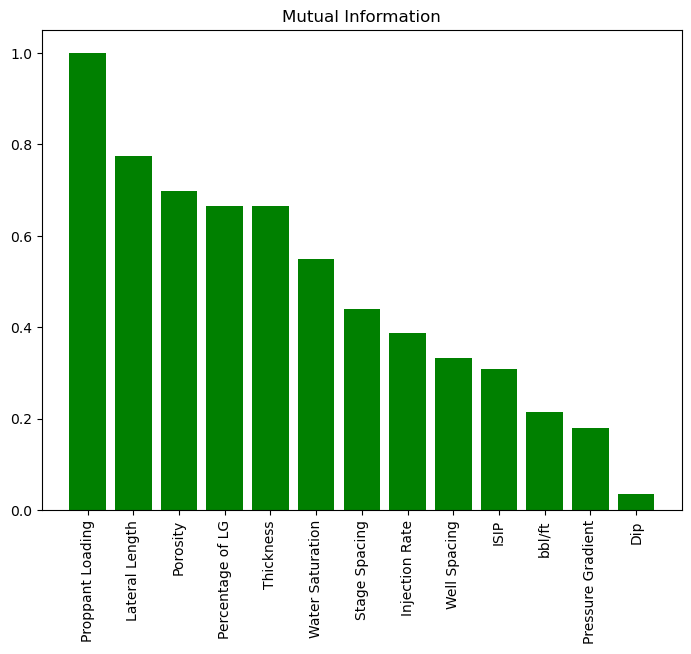

In [35]:
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[13]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()


### Linear Regression

The dataset is split into training and testing sets, and the features are normalized using StandardScaler. A Linear Regression model is then initialized, trained with the scaled training data, and evaluated on the test set. The script prints the model's intercept and coefficients, calculates the Root Mean Squared Error (RMSE), and computes the Coefficient of Determination (R²) as performance metrics. Finally, it visualizes the model's predictions against the actual values through a scatter plot, providing a graphical representation of the model's predictive accuracy.

Intercept: 13.006214689265535
Coefficients: [-0.38691574  0.28826025 -1.06020811  0.26489973  0.60607194  0.96335625
  0.13078276 -0.10100177 -0.70509575 -0.47805859 -0.68573627  0.34768261
  1.30191325]
Root Mean Squared Error: 1.5799052885191456
Coefficient of Determination (R^2): 0.6982202815810612


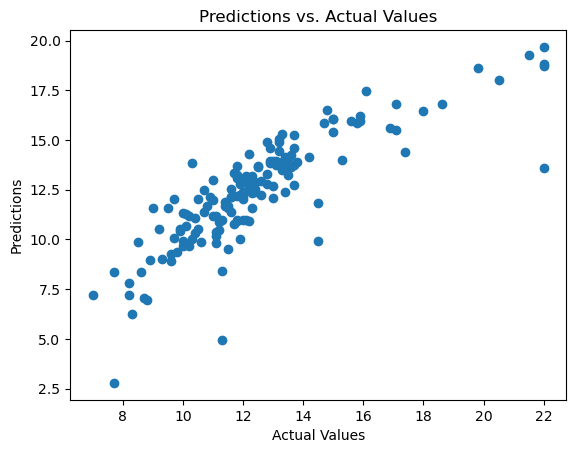

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the linear regression model
model = LinearRegression()

# Train the model with the training data
model.fit(X_train_scaled, y_train)

# Print the intercept and coefficients
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2_score(y_test, predictions))

# Visualize predictions vs. actual values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Actual Values')
plt.show()


### Random Forest 
We employed a scikit-learn to perform hyperparameter tuning for a Random Forest Regressor. The dataset is split into training and test sets, and a grid search is conducted over a range of hyperparameters, including the number of estimators, maximum depth, minimum samples split, and minimum samples leaf. The model is then trained using the training data with the optimal hyperparameters identified through the grid search. Subsequently, predictions are made on the test set, and performance metrics such as Root Mean Squared Error (RMSE), Mean Squared Error, and Coefficient of Determination (R²) are calculated and printed. The script also visualizes the model's predictions against the actual values using a scatter plot and displays the feature importance through a horizontal bar chart. This comprehensive approach aims to optimize the Random Forest model and provide insights into the importance of different features in predicting the target variable.

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Root Mean Squared Error (Random Forest): 1.0310773816815828
Mean Squared Error (Random Forest): 1.0631205670153483
Coefficient of Determination (R^2) (Random Forest): 0.8691542524432028


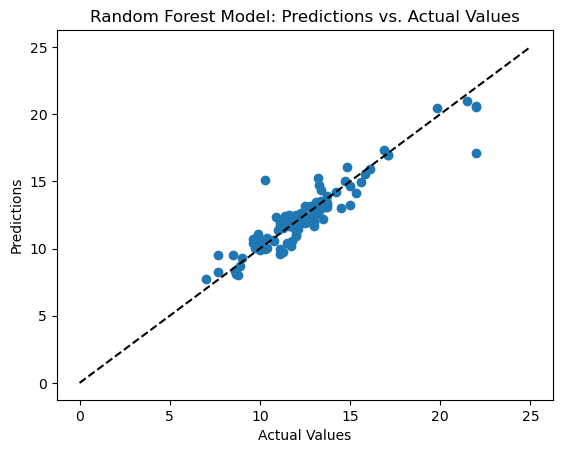

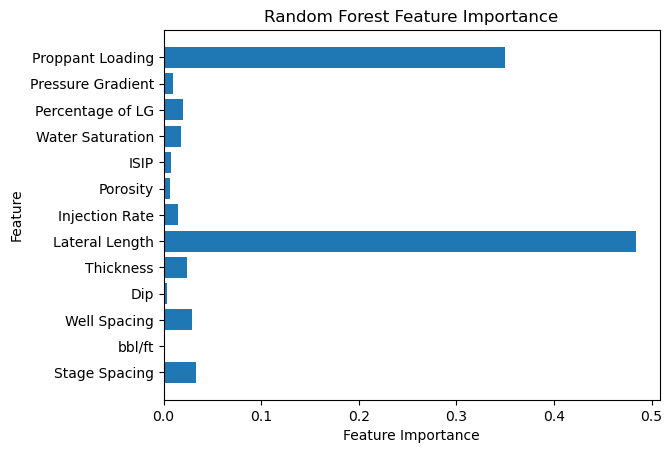

In [37]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Perform hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)

# Use the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Train the model with the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)

# Calculate and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print('Root Mean Squared Error (Random Forest):', rmse)



# Evaluate the model performance
print('Mean Squared Error (Random Forest):', mean_squared_error(y_test, rf_predictions))
print('Coefficient of Determination (R^2) (Random Forest):', r2_score(y_test, rf_predictions))

# Visualize predictions vs. actual values
plt.plot([0, 25], [0, 25], color='black', linestyle='--', label='1:1 Line')
plt.scatter(y_test, rf_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model: Predictions vs. Actual Values')
plt.show()

# Visualize feature importance
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns

plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


### Support Vector Machine (Regression)

We used Support Vector Regression (SVR) for predicting Estimated Ultimate Recovery (EUR) in unconventional wells. The dataset is split into training and test sets, and the features are selected as 'Well Spacing,' 'Thickness,' 'Lateral Length,' 'Porosity,' 'Water Saturation,' 'Percentage of LG,' and 'Proppant Loading.' The script normalizes the data using StandardScaler and performs SVR with a radial basis function kernel. The relationship between different regularization parameter values (C) and Root Mean Squared Error (RMSE) is explored through a log-scale plot, aiding in the identification of the optimal C value. The script then trains an SVR model with the optimal C value and evaluates its performance on the test set, reporting the RMSE and Coefficient of Determination (R²). Finally, a scatter plot visualizes the predictions against actual values, providing a clear representation of the model's performance with the chosen hyperparameter.

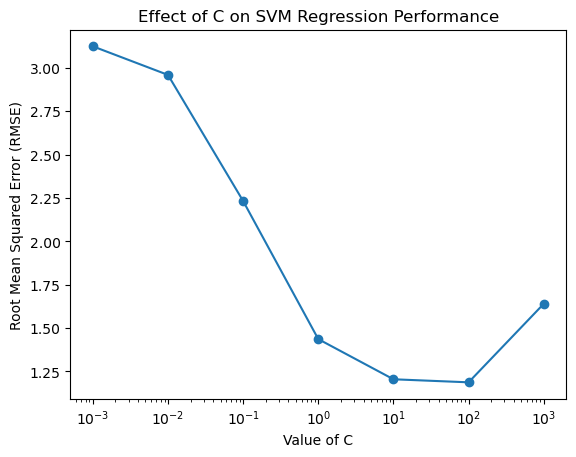

Optimal C: 100
Root Mean Squared Error (SVM) with Optimal C: 1.1651085323170913
Coefficient of Determination (R^2) (SVM) with Optimal C: 0.8329256200174535


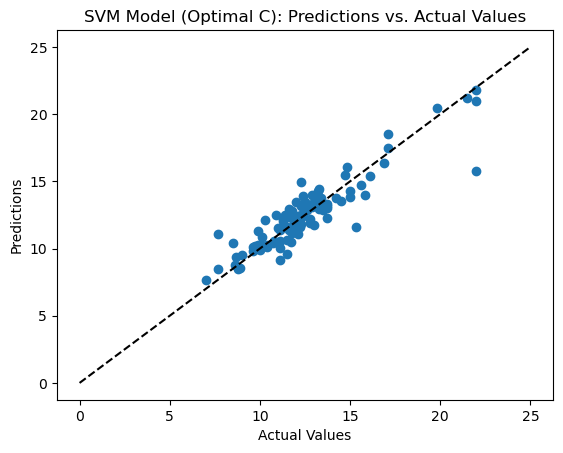

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with the features and target
features = df[['Well Spacing', 'Thickness', 'Lateral Length', 'Porosity', 'Water Saturation', 'Percentage of LG', 'Proppant Loading']]
target = df['EUR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100,1000]

# Store RMSE scores for each C value
rmse_scores = []

# Loop through different C values
for C_val in C_values:
    # Create and train the SVM regression model
    svm_model = SVR(kernel='rbf', C=C_val, epsilon=0.1)
    svm_model.fit(X_train_scaled, y_train)

    # Cross-validation to evaluate model performance
    scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

# Plot the relationship between C and RMSE
plt.plot(C_values, rmse_scores, marker='o')
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('Value of C')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Effect of C on SVM Regression Performance')

# Show the plot
plt.show()

# Choose the optimal C value based on the plot or other criteria
optimal_C = C_values[np.argmin(rmse_scores)]

# Create and train the SVM regression model with the optimal C value
svm_model_optimal = SVR(kernel='rbf', C=optimal_C, epsilon=0.1)
svm_model_optimal.fit(X_train_scaled, y_train)

# Make predictions on the test set
svm_predictions_optimal = svm_model_optimal.predict(X_test_scaled)

# Evaluate the model performance on the test set with optimal C
print('Optimal C:', optimal_C)
print('Root Mean Squared Error (SVM) with Optimal C:', np.sqrt(mean_squared_error(y_test, svm_predictions_optimal)))
print('Coefficient of Determination (R^2) (SVM) with Optimal C:', r2_score(y_test, svm_predictions_optimal))

# Visualize predictions vs. actual values for the model with optimal C
plt.plot([0,25], [0,25], color='black', linestyle='--', label='1:1 Line')
plt.scatter(y_test, svm_predictions_optimal)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('SVM Model (Optimal C): Predictions vs. Actual Values')
plt.show()

## Conclusions 

In comparing the performance of three regression models on the given dataset, the Root Mean Squared Error (RMSE) serves as a key metric for assessing predictive accuracy. The Random Forest model demonstrates the lowest RMSE (1.0916), indicating superior predictive performance compared to the Support Vector Machine (SVM) model with an RMSE of 1.1651 and the Linear model with an RMSE of 1.5799. The lower RMSE values signify a better ability to predict the target variable. It's noteworthy that the SVM model is highlighted for its faster computation speed, adding an efficiency dimension to the comparison. These findings underscore the effectiveness of the Random Forest model in this predictive task, while also acknowledging the SVM model's computational efficiency."



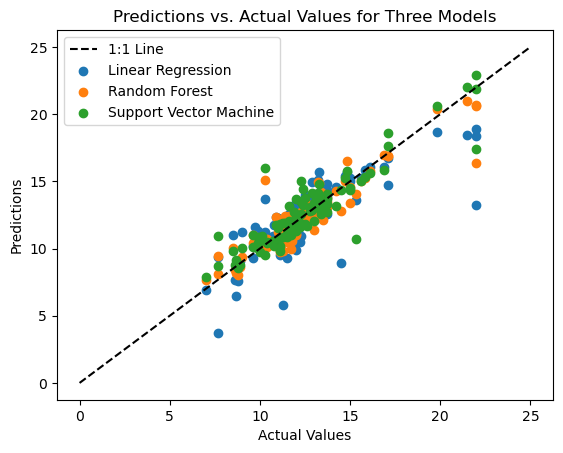

In [39]:
# Assuming df is your DataFrame with the features and target
features = df[['Stage Spacing', 'Well Spacing', 'Thickness', 'Lateral Length', 'Injection Rate', 'Porosity', 'Water Saturation', 'Percentage of LG', 'Proppant Loading']]
target = df['EUR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
linear_model = LinearRegression()
rf_model = RandomForestRegressor()
svm_model = SVR(kernel='rbf', C=optimal_C, epsilon=0.1)

# Train the models with the training data
linear_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test_scaled)
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test_scaled)

# Visualize predictions vs. actual values for all three models
plt.plot([0, 25], [0, 25], color='black', linestyle='--', label='1:1 Line')
plt.scatter(y_test, linear_predictions, label='Linear Regression')
plt.scatter(y_test, rf_predictions, label='Random Forest')
plt.scatter(y_test, svm_predictions, label='Support Vector Machine')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Actual Values for Three Models')
plt.legend()
plt.show()